In [32]:
import librosa
import os
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct
from librosa.feature import mfcc
from IPython.display import Audio
import pandas as pd

In [2]:
audiopath=r"C:\Users\vibha srinivasan\Downloads\VoiceSpoof-project\audioflac\LA_E_1000166.flac"

In [3]:
signal, sr = librosa.load(audiopath, sr=None)
Audio(signal, rate=sr)

Signal shape: (132480,)
Sampling rate: 16000 Hz
Duration: 8.28 seconds


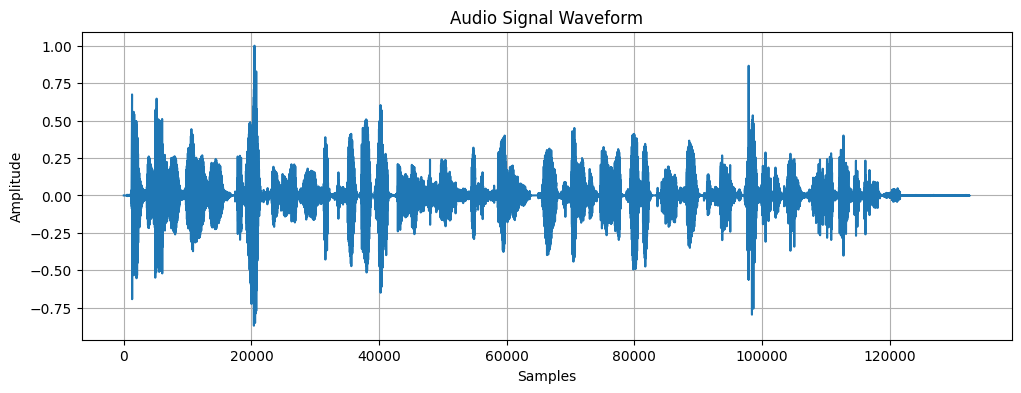

In [5]:
print(f"Signal shape: {signal.shape}")
print(f"Sampling rate: {sr} Hz")
print(f"Duration: {len(signal) / sr:.2f} seconds")

plt.figure(figsize=(12, 4))
plt.plot(signal)
plt.title('Audio Signal Waveform')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [8]:
def spectral_subtraction(signal, noise_estimation_factor=0.1):
    """Apply spectral subtraction for noise reduction."""
    # Compute the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(signal)
    
    # Compute magnitude and phase
    magnitude, phase = np.abs(stft), np.angle(stft)
    
    # Estimate noise by taking the average magnitude spectrum
    noise_magnitude = np.mean(magnitude, axis=1, keepdims=True) * noise_estimation_factor
    
    # Subtract noise from magnitude
    magnitude_clean = np.maximum(magnitude - noise_magnitude, 0)
    
    # Reconstruct the signal from cleaned magnitude and original phase
    cleaned_stft = magnitude_clean * np.exp(1j * phase)
    cleaned_signal = librosa.istft(cleaned_stft)
    
    return cleaned_signal

def preprocess_audio(file_path, sr=16000):
    # Load audio file
    signal, sr = librosa.load(file_path, sr=sr)
    
    # Normalize the audio signal
    signal = signal / np.max(np.abs(signal))

    # Pre-emphasis filter
    pre_emphasis = 0.97
    signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Remove silence (optional)
    # Use librosa's effects module to trim silence
    signal, _ = librosa.effects.trim(signal)

    cleaned_signal = spectral_subtraction(signal)

    return signal, sr

Audio(signal, rate=sr)



In [9]:
print(f"Sample Rate: {sr}")
print(f"Processed Signal Length: {len(signal)}")
print(f"Processed Signal: {signal[:10]}") 

Sample Rate: 16000
Processed Signal Length: 132480
Processed Signal: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


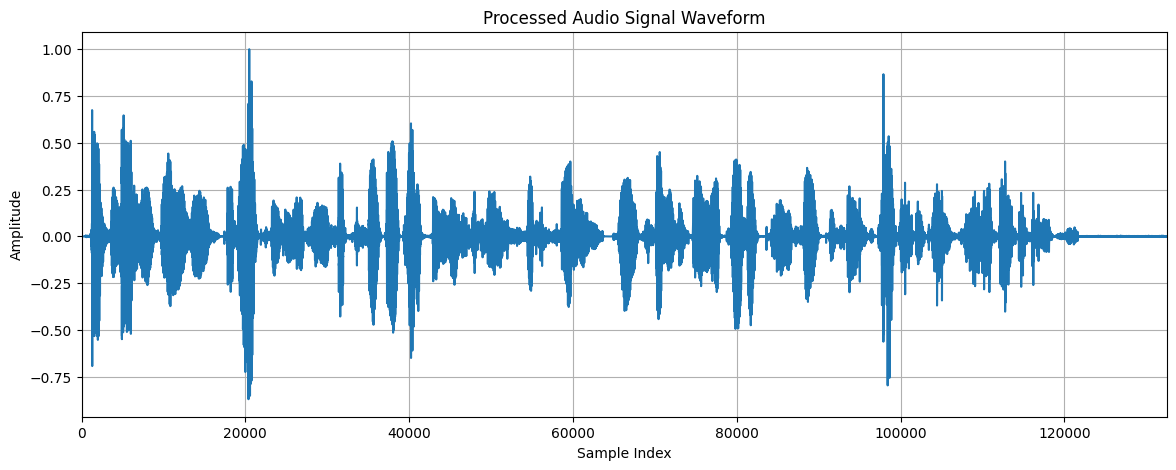

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(signal)
plt.title('Processed Audio Signal Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.xlim(0, len(signal))
plt.grid()
plt.show()

In [11]:
def extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    # Pre-emphasis
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)
    hop_length = frame_length_in_samples // 2
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Compute the magnitude spectrum
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
    
    # Keep only the first half of the spectrum
    fr_all = fr_all[:, :NFFT // 2 + 1]

    # Mel filter bank
    mel_filters = librosa.filters.mel(sr=Fs, n_fft=NFFT, n_mels=No_Filter, fmin=0, fmax=Fs // 2)
    
    # Apply the filter bank
    mel_spectrum = np.dot(fr_all, mel_filters.T)  # This should work now as dimensions align
    
    # Logarithm
    log_mel_spectrum = np.log10(mel_spectrum + np.finfo(float).eps)
    
    # Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :No_Filter]
    
    # Calculate delta and double delta
    delta = librosa.feature.delta(mfccs)
    double_delta = librosa.feature.delta(mfccs, order=2)

    return mfccs, delta, double_delta

In [12]:
speech = np.random.randn(sr)
Window_Length = 25  # in milliseconds
NFFT = 512  # number of FFT bins
No_Filter = 20
mfccs, delta, double_delta = extract_mfcc(signal, sr, Window_Length, NFFT, No_Filter)

In [13]:
print("MFCCs shape:", mfccs.shape)  # Expecting (number_of_frames, No_Filter)
print("Delta MFCC shape:", delta.shape)  # Expecting (number_of_frames, No_Filter)
print("Double Delta MFCC shape:", double_delta.shape)  # Expecting (number_of_frames, No_Filter)

# Print the first few values of each output
print("MFCCs (first 3 values):", mfccs[0:3])  # First 3 frames
print("Delta MFCC (first 3 values):", delta[0:3])  # First 3 frames
print("Double Delta MFCC (first 3 values):", double_delta[0:3])

MFCCs shape: (661, 20)
Delta MFCC shape: (661, 20)
Double Delta MFCC shape: (661, 20)
MFCCs (first 3 values): [[-3.66497332e+01 -3.95775592e-01  3.77038021e-01  5.89792907e-01
   6.36202062e-01  4.44420285e-01  9.88192357e-02  1.27760770e-01
  -1.00616291e-01  3.80885480e-01  2.55478201e-01  3.84050572e-02
   1.64960844e-01  1.86656795e-01 -3.29692260e-02  4.58856717e-02
  -3.81005960e-02 -2.84904371e-02 -4.35272706e-02 -7.07952323e-02]
 [-2.98493903e+01 -8.54036763e-01 -7.31910912e-01  1.30421422e-01
   8.27617826e-01  5.52316715e-01 -6.11931593e-01 -3.76453471e-01
  -1.87476283e-01  7.99974873e-02 -1.99934229e-01  2.10951704e-01
   2.71009468e-01  4.11713919e-02  3.06518713e-01 -1.04105235e-01
   4.66869953e-02  4.66515642e-02 -1.13959430e-02  1.22419528e-01]
 [-2.54513298e+01 -9.69998777e-01 -4.14172376e-01 -1.63812051e-02
   6.08528754e-01  6.60083877e-01 -1.09543458e-01 -4.26119333e-01
  -1.48779382e-01 -3.08185906e-02 -2.98567043e-01  9.20834521e-02
   8.21434269e-02  9.32294608e

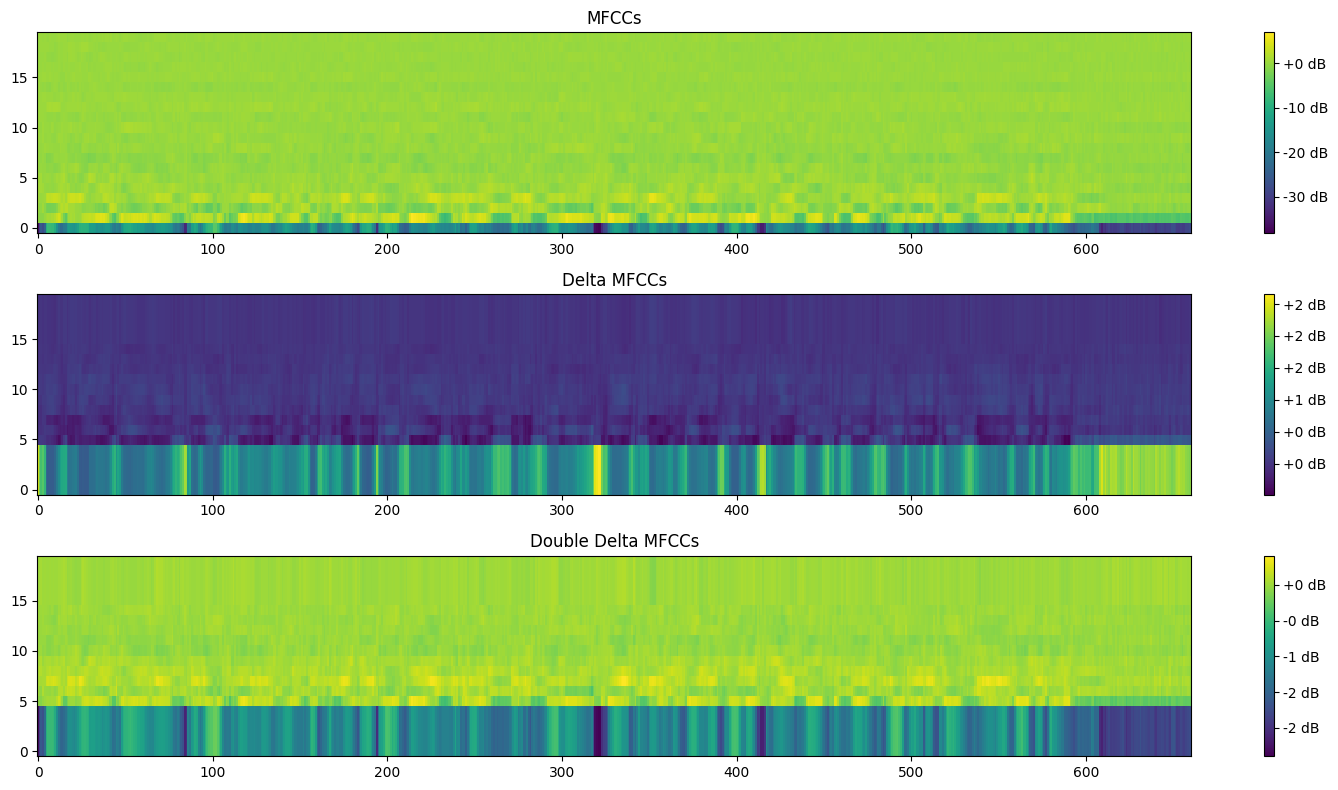

In [14]:
plt.figure(figsize=(15, 8))

# MFCCs
plt.subplot(3, 1, 1)
plt.imshow(mfccs.T, aspect='auto', origin='lower', interpolation='none')
plt.title('MFCCs')
plt.colorbar(format='%+2.0f dB')

# Delta
plt.subplot(3, 1, 2)
plt.imshow(delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta MFCCs')
plt.colorbar(format='%+2.0f dB')

# Double Delta
plt.subplot(3, 1, 3)
plt.imshow(double_delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta MFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [15]:
def trimf(x, params):
    if len(params) != 3:
        raise ValueError("trimf requires params to be a list of 3 elements")
    a, b, c = params
    y = np.zeros_like(x)
    if a < b:
        index = (x > a) & (x < b)
        y[index] = (x[index] - a) / (b - a)
    if b < c:
        index = (x > b) & (x < c)
        y[index] = (c - x[index]) / (c - b)
    y[x == b] = 1.0
    return y

In [16]:
def deltas(features, N=3):
    """
    Compute the delta coefficients of the input features.
    N: Number of frames for the delta computation.
    """
    if len(features.shape) == 1:
        features = features[:, np.newaxis]  # Ensure features are 2D
    delta = np.zeros_like(features)
    for t in range(features.shape[0]):
        for i in range(features.shape[1]):
            if t < N:
                delta[t, i] = np.sum((np.arange(1, N + 1) * (features[min(t + N, features.shape[0] - 1), i] - features[t, i])))/N
            elif t >= features.shape[0] - N:
                delta[t, i] = np.sum((np.arange(1, N + 1) * (features[t, i] - features[max(t - N, 0), i])))/N
            else:
                delta[t, i] = np.sum((np.arange(1, N + 1) * (features[t + N, i] - features[t - N, i])))/(2 * N)
    return delta

In [17]:
def extract_lfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    # Pre-emphasis
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)
    hop_length = frame_length_in_samples // 2
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Frequency and filter bank
    f = (Fs / 2) * np.linspace(0, 1, NFFT // 2 + 1)
    filter_bandwidths = np.linspace(min(f), max(f), No_Filter + 2)
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
    fa_all = fr_all[:, :NFFT // 2 + 1]
    
    # Filter bank creation
    filterbank = np.zeros((NFFT // 2 + 1, No_Filter))
    for i in range(No_Filter):
        filterbank[:, i] = trimf(f, [filter_bandwidths[i], filter_bandwidths[i + 1], filter_bandwidths[i + 2]])
    
    filbanksum = np.dot(fa_all, filterbank)

    # Calculate static LFCC
    t = dct(np.log10(filbanksum + np.finfo(float).eps), type=2, axis=1, norm='ortho')[:, :No_Filter]
    stat = t.T
    
    # Calculate delta and double delta
    delta = deltas(stat, 3).T
    double_delta = deltas(delta, 3).T

    return stat, delta, double_delta

In [19]:
Window_Length = 25  # in milliseconds
NFFT = 512  # number of FFT bins
No_Filter = 20

stat, delta, double_delta = extract_lfcc(signal, sr, Window_Length, NFFT, No_Filter)

In [20]:
print("Static LFCC shape:", stat.shape)
print("Delta LFCC shape:", delta.shape)
print("Double Delta LFCC shape:", double_delta.shape)


print("Static LFCC (first 3 values):", stat[0:3])
print("Delta LFCC (first 3 values):", delta[0:3])
print("Double Delta LFCC (first 3 values):", double_delta[0:3])

Static LFCC shape: (20, 661)
Delta LFCC shape: (661, 20)
Double Delta LFCC shape: (20, 661)
Static LFCC (first 3 values): [[-24.85760209 -18.24812758 -13.77171514 ... -13.89504137 -13.39568522
  -13.93603136]
 [ -0.21971535   0.53365256   0.27111959 ...  -1.63530886  -1.52844317
   -1.52586643]
 [ -0.37162756  -0.86270192  -0.98002063 ...  -4.13601419  -3.85385865
   -3.27093624]]
Delta LFCC (first 3 values): [[ 5.02473311e+01 -1.32134773e-01  8.40554302e-01  2.49314814e+01
   5.26140292e-01  4.66972070e-01 -2.50664300e-01  3.27696397e-01
   2.12510210e-01  1.76064118e-01 -1.20761918e-01 -1.73918552e-02
   1.08963792e-01 -1.48141451e-01 -5.58713429e-02 -3.16433937e-01
  -3.62460720e-01  2.54671608e-01 -3.81706851e-01 -1.41139811e-01]
 [ 3.74243033e+01 -2.93273680e+00  1.26809666e+00  1.76661647e+01
  -2.96821395e-01  1.42355452e-01  2.48141032e-01  1.11131535e+00
   6.45539055e-01  4.74385380e-01  2.68637031e-02  7.73134179e-01
  -5.45932140e-01 -1.71558217e-01 -4.57960218e-01  1.19966

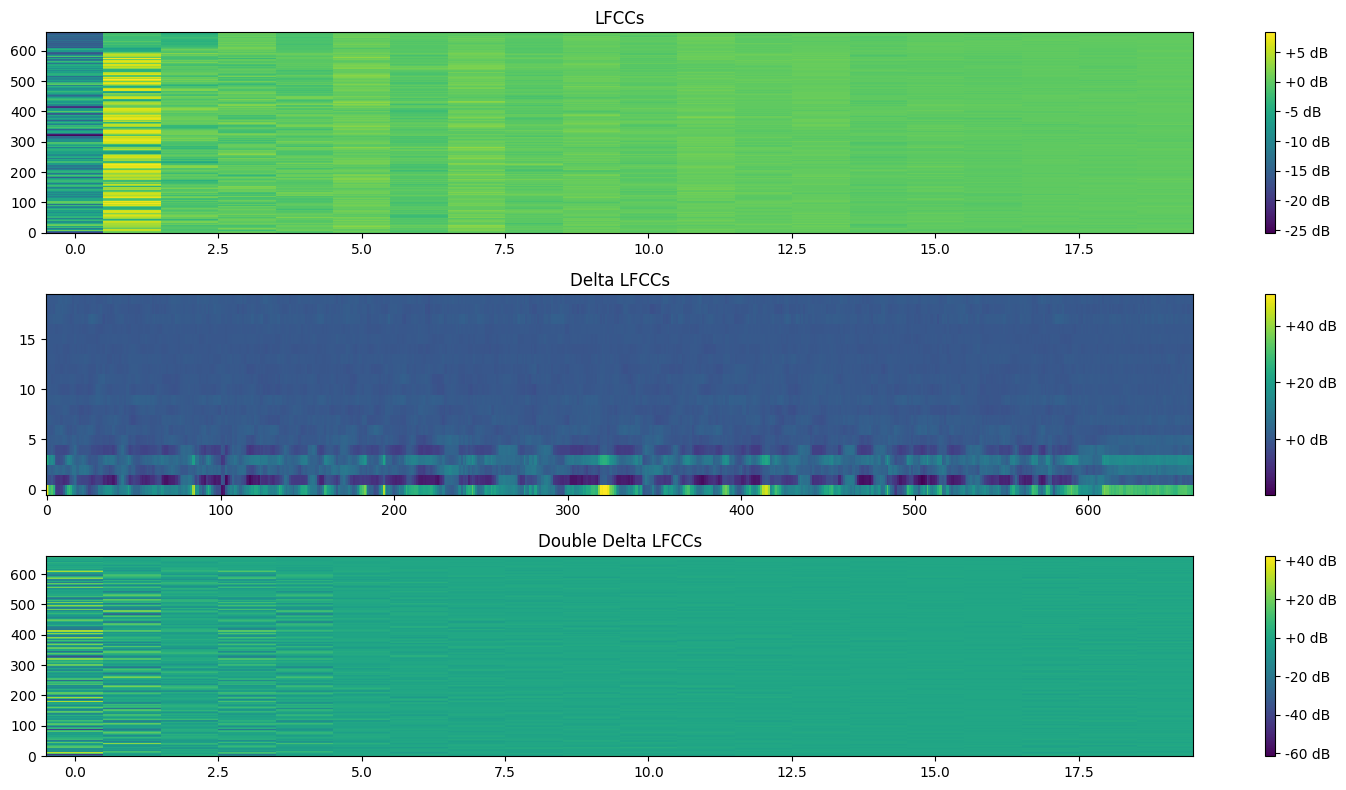

In [21]:
plt.figure(figsize=(15, 8))

# LFCCs
plt.subplot(3, 1, 1)
plt.imshow(stat.T, aspect='auto', origin='lower', interpolation='none')
plt.title('LFCCs')
plt.colorbar(format='%+2.0f dB')

# Delta LFCCs
plt.subplot(3, 1, 2)
plt.imshow(delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

# Double Delta LFCCs
plt.subplot(3, 1, 3)
plt.imshow(double_delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta LFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [22]:
def extract_mfcc(speech, Fs, Window_Length, NFFT, No_Filter):
    # Pre-emphasis
    speech = np.append(speech[0], speech[1:] - 0.97 * speech[:-1])
    
    # Framing and windowing
    frame_length_in_samples = int((Fs / 1000) * Window_Length)
    hop_length = frame_length_in_samples // 2
    framedspeech = librosa.util.frame(speech, frame_length=frame_length_in_samples, hop_length=hop_length).T
    w = np.hamming(frame_length_in_samples)
    y_framed = framedspeech * w
    
    # Compute the magnitude spectrum
    fr_all = np.abs(np.fft.fft(y_framed, NFFT))**2
    
    # Keep only the first half of the spectrum
    fr_all = fr_all[:, :NFFT // 2 + 1]

    # Mel filter bank
    mel_filters = librosa.filters.mel(sr=Fs, n_fft=NFFT, n_mels=No_Filter, fmin=0, fmax=Fs // 2)
    
    # Apply the filter bank
    mel_spectrum = np.dot(fr_all, mel_filters.T)  # This should work now as dimensions align
    
    # Logarithm
    log_mel_spectrum = np.log10(mel_spectrum + np.finfo(float).eps)
    
    # Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :No_Filter]
    
    # Calculate delta and double delta
    delta = librosa.feature.delta(mfccs)
    double_delta = librosa.feature.delta(mfccs, order=2)

    return mfccs, delta, double_delta

In [24]:
speech = np.random.randn(sr) 

Window_Length = 25  # in milliseconds
NFFT = 512  # number of FFT bins
No_Filter = 20
mfccs, delta, double_delta = extract_mfcc(signal, sr, Window_Length, NFFT, No_Filter)


In [25]:
print("MFCCs shape:", mfccs.shape)  # Expecting (number_of_frames, No_Filter)
print("Delta MFCC shape:", delta.shape)  # Expecting (number_of_frames, No_Filter)
print("Double Delta MFCC shape:", double_delta.shape)  # Expecting (number_of_frames, No_Filter)

# Print the first few values of each output
print("MFCCs (first 3 values):", mfccs[0:3])  # First 3 frames
print("Delta MFCC (first 3 values):", delta[0:3])  # First 3 frames
print("Double Delta MFCC (first 3 values):", double_delta[0:3])

MFCCs shape: (661, 20)
Delta MFCC shape: (661, 20)
Double Delta MFCC shape: (661, 20)
MFCCs (first 3 values): [[-3.66497332e+01 -3.95775592e-01  3.77038021e-01  5.89792907e-01
   6.36202062e-01  4.44420285e-01  9.88192357e-02  1.27760770e-01
  -1.00616291e-01  3.80885480e-01  2.55478201e-01  3.84050572e-02
   1.64960844e-01  1.86656795e-01 -3.29692260e-02  4.58856717e-02
  -3.81005960e-02 -2.84904371e-02 -4.35272706e-02 -7.07952323e-02]
 [-2.98493903e+01 -8.54036763e-01 -7.31910912e-01  1.30421422e-01
   8.27617826e-01  5.52316715e-01 -6.11931593e-01 -3.76453471e-01
  -1.87476283e-01  7.99974873e-02 -1.99934229e-01  2.10951704e-01
   2.71009468e-01  4.11713919e-02  3.06518713e-01 -1.04105235e-01
   4.66869953e-02  4.66515642e-02 -1.13959430e-02  1.22419528e-01]
 [-2.54513298e+01 -9.69998777e-01 -4.14172376e-01 -1.63812051e-02
   6.08528754e-01  6.60083877e-01 -1.09543458e-01 -4.26119333e-01
  -1.48779382e-01 -3.08185906e-02 -2.98567043e-01  9.20834521e-02
   8.21434269e-02  9.32294608e

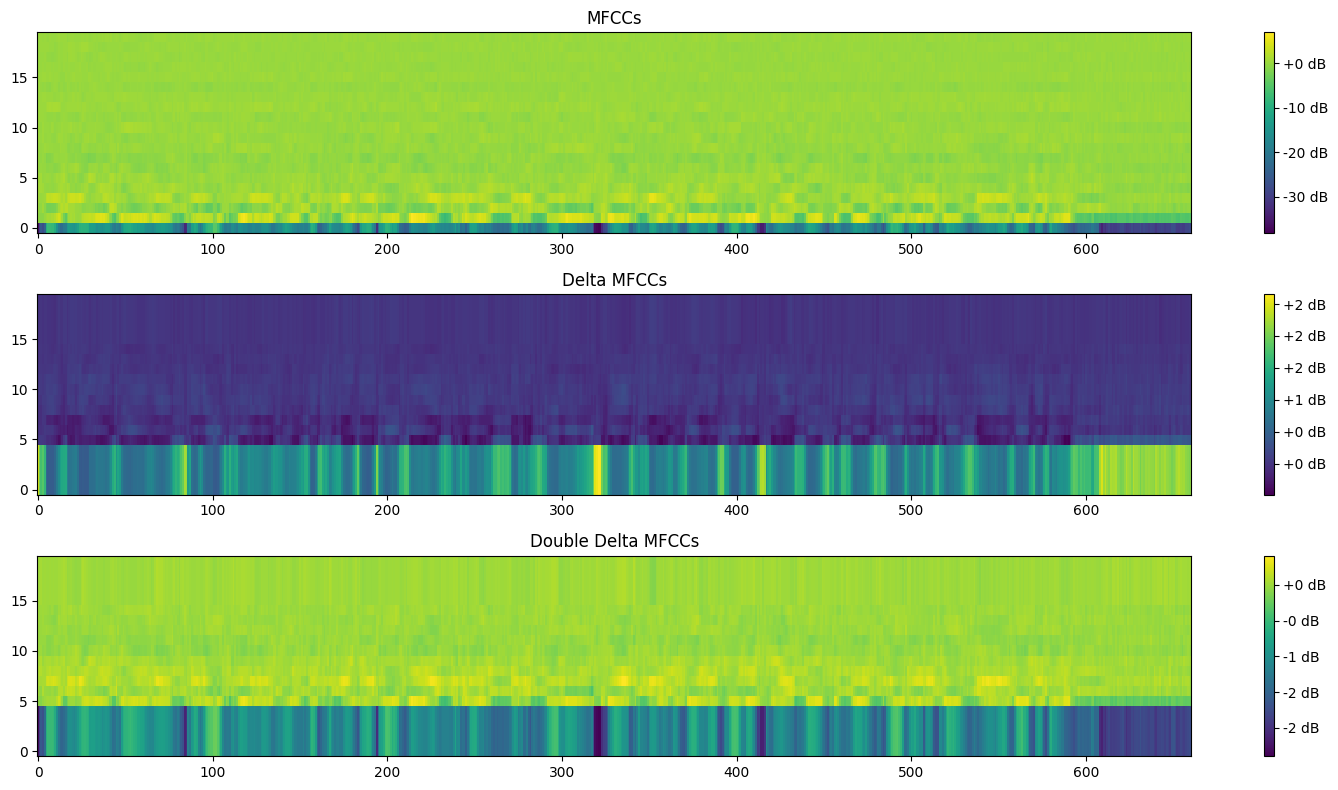

In [26]:
plt.figure(figsize=(15, 8))

# MFCCs
plt.subplot(3, 1, 1)
plt.imshow(mfccs.T, aspect='auto', origin='lower', interpolation='none')
plt.title('MFCCs')
plt.colorbar(format='%+2.0f dB')

# Delta
plt.subplot(3, 1, 2)
plt.imshow(delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Delta MFCCs')
plt.colorbar(format='%+2.0f dB')

# Double Delta
plt.subplot(3, 1, 3)
plt.imshow(double_delta.T, aspect='auto', origin='lower', interpolation='none')
plt.title('Double Delta MFCCs')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [36]:
def fuse_features(mfccs, lfccs):
    # Get the number of frames for both MFCC and LFCC
    mfcc_frames = mfccs.shape[0]
    lfcc_frames = lfccs.shape[0]

    # Determine which one has fewer frames
    if mfcc_frames < lfcc_frames:
        padding = np.zeros((lfcc_frames - mfcc_frames, mfccs.shape[1]))
        mfccs = np.vstack([mfccs, padding])
    elif lfcc_frames < mfcc_frames:
        padding = np.zeros((mfcc_frames - lfcc_frames, lfccs.shape[1]))
        lfccs = np.vstack([lfccs, padding])

    # Fuse features along the coefficient axis
    combined_features = np.concatenate((mfccs, lfccs), axis=1)

    combined_df = pd.DataFrame(combined_features)
    csv_file_path = 'combined_features.csv'  # Change this path as needed
    combined_df.to_csv(csv_file_path, index=False)
    
    return combined_features, csv_file_path
    

MFCC Shape: (661, 20)
LFCC Shape: (20, 661)
Fused Features Shape: (661, 681)


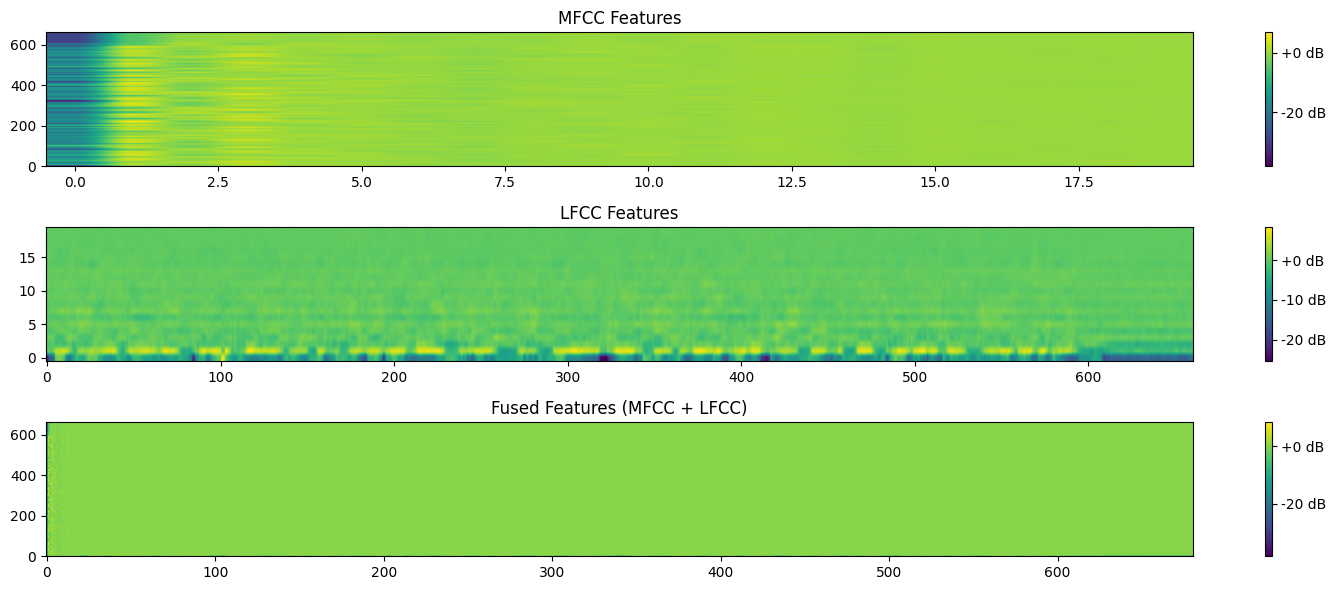

Combined features saved to combined_features.csv


In [37]:
def plot_features(mfccs, lfccs, fused_features):
    plt.figure(figsize=(15, 6))

    # Plot MFCCs
    plt.subplot(3, 1, 1)
    plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis')
    plt.title('MFCC Features')
    plt.colorbar(format='%+2.0f dB')

    # Plot LFCCs
    plt.subplot(3, 1, 2)
    plt.imshow(lfccs, aspect='auto', origin='lower', cmap='viridis')
    plt.title('LFCC Features')
    plt.colorbar(format='%+2.0f dB')

    # Plot Fused Features
    plt.subplot(3, 1, 3)
    plt.imshow(fused_features, aspect='auto', origin='lower', cmap='viridis')
    plt.title('Fused Features (MFCC + LFCC)')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

mfccs, _, _ = extract_mfcc(signal, sr, Window_Length, NFFT, No_Filter)  
lfccs, _, _ = extract_lfcc(signal, sr, Window_Length, NFFT, No_Filter)  

# Fuse MFCC and LFCC features
fused_features,csv_file_path = fuse_features(mfccs, lfccs)

print(f"MFCC Shape: {mfccs.shape}")
print(f"LFCC Shape: {lfccs.shape}")
print(f"Fused Features Shape: {fused_features.shape}")

plot_features(mfccs, lfccs, fused_features)

print(f"Combined features saved to {csv_file_path}")